# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [3]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [5]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [ ]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

In [4]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [5]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [6]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [7]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [5]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [12]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [6]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [7]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [8]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

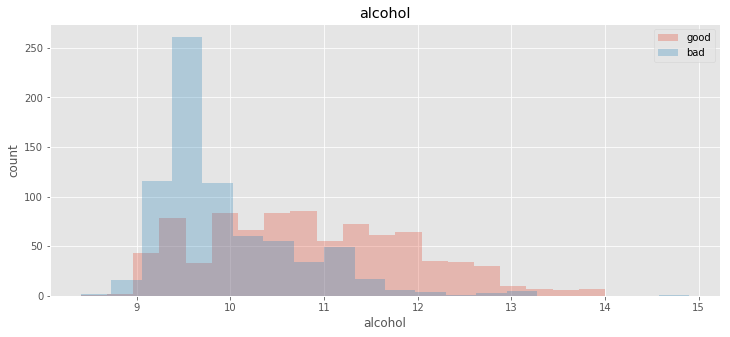

In [28]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [53]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

[[  7.4     0.7     0.    ...,   0.56    9.4     0.   ]
 [  7.8     0.88    0.    ...,   0.68    9.8     0.   ]
 [  7.8     0.76    0.04  ...,   0.65    9.8     0.   ]
 ..., 
 [  6.3     0.51    0.13  ...,   0.75   11.      1.   ]
 [  5.9     0.645   0.12  ...,   0.71   10.2     0.   ]
 [  6.      0.31    0.47  ...,   0.66   11.      1.   ]]
+++++
[[  7.4     0.7     0.    ...,   3.51    0.56    9.4  ]
 [  7.8     0.88    0.    ...,   3.2     0.68    9.8  ]
 [  7.8     0.76    0.04  ...,   3.26    0.65    9.8  ]
 ..., 
 [  6.3     0.51    0.13  ...,   3.42    0.75   11.   ]
 [  5.9     0.645   0.12  ...,   3.57    0.71   10.2  ]
 [  6.      0.31    0.47  ...,   3.39    0.66   11.   ]]


Далее вы увидете пример реализации этого простого классификатора.

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
        
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
        
            error_rate = sum(prediction != y)/n
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [30]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [54]:
y_hat = model.predict(X)
y_hat

array([0, 0, 0, ..., 1, 1, 1])

Оценим долю ошибок на обучающей выборке

In [55]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [18]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [20]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
print y_test
y_hat = model.predict(X_test)

[1 1 1 ..., 1 1 1]


In [21]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.334831


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [9]:
from sklearn.base import ClusterMixin
import random
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
    
    def init_centroids(self, centroid_count, dimension, point_count, X):
        self.centroids = np.empty((centroid_count, dimension))
        num = np.arange(0, point_count - 1, 1)
        random_centroids = random.sample(num, centroid_count)
        for i in range(0, centroid_count):
            self.centroids[i] = X[random_centroids[i]]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        n = X.shape[0]
        dimension = X.shape[1]
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(n)
        
        self.init_centroids(self.k, dimension, n, X)
            
        eps = 0.001
        error = 100
        current_iter = 0
        
        while (error >= eps and current_iter < self.max_iter):
            dist = cdist(self.centroids, X, metric=self.metric)
            
            """
            В этом массиве на i-ом месте стоит кол-во точек, отоносящихся к i-ому центроиду
            """
            
            cnt_points_in_centroids = np.zeros(self.k, dtype=float)
            
            """
            В этом массиве на i-ом месте хранится сумма точек, относящихся к i-ому центроиду
            """
            sum_points_for_centroids = np.zeros((self.k, X.shape[1]), dtype=float)
            
            """
            Пересчитываем расстояния между центроидами и точками
            """
            for point in range(0, n):
                best_centroid = -1;
                dist_to_best_centroid = 0;
                for centroid in range(0, self.k):
                    if (best_centroid == -1 or dist_to_best_centroid > dist[centroid][point]):
                        dist_to_best_centroid = dist[centroid][point]
                        best_centroid = centroid
                self.labels[point] = best_centroid
                cnt_points_in_centroids[best_centroid] += 1
                sum_points_for_centroids[best_centroid] += X[point]
                
            """
            Обновляем центроиды
            """
            error = 0
            for i in range(0, self.k):
                tmp = sum_points_for_centroids[i] / float(cnt_points_in_centroids[i])
                error += pdist((self.centroids[i], tmp), 'euclidean')
                self.centroids[i] = tmp
            current_iter += 1
        
        return self
    
    def get_centroids(self):
        return self.centroids

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = cdist(self.centroids, X, metric=self.metric)
        result = np.zeros(X.shape[0], dtype=int)
        for point in range(0, X.shape[0]):
            best_centroid = -1;
            dist_to_best_centroid = 0;
            for centroid in range(0, self.k):
                if (best_centroid == -1 or dist_to_best_centroid > dist[centroid][point]):
                    dist_to_best_centroid = dist[centroid][point]
                    best_centroid = centroid
            result[point] = best_centroid
        return result
        

class MiniBatchKMeans(Kmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size=10):
        self.batch_size = batch_size
        Kmeans.__init__(self, k, metric=metric, max_iter=max_iter, random_state=random)
        
        
    def fit(self, X, y=None):
        """
        Процедура обучения k-means with minibatch
        """
        n = X.shape[0]
        dimension = X.shape[1]
        
        """
        Проинициализируем центроиды случайными точками из набора
        """
        self.init_centroids(self.k, dimension, n, X)
            
        """
        Инициализация счетчика для центроидов
        """
        counts_per_centroid = np.zeros(self.k)
        
        for cur_iter in range(self.max_iter):
            
            num = np.arange(0, n - 1, 1)
            random_points_index = random.sample(num, self.batch_size)
            random_points = np.empty((self.batch_size, X.shape[1]))
            for i in range(0, self.batch_size):
                random_points[i] = X[random_points_index[i]]
        
            """
            Проставим близжайшие центроиды для нашего batch'а
            """
            cached_centroid = np.empty(self.batch_size, dtype=int)
            """
            Инициализируем расстояния между центроидами и точками из batch
            """
            dist = cdist(self.centroids, random_points, metric=self.metric)
            for point in range(self.batch_size):
                best_centroid = -1
                best_distance = 0
                for centroid in range(self.k):
                    if (best_centroid == -1 or best_distance > dist[centroid][point]):
                        best_centroid = centroid
                        best_distance = dist[centroid][point]
                cached_centroid[point] = best_centroid
            
            """
            Обновляем центроиды, используя выбранные точки
            """
            for point in range(self.batch_size):
                point_centroid = cached_centroid[point]
                counts_per_centroid[point_centroid] += 1
                centroid_rate = 1 / counts_per_centroid[point_centroid]
                
                self.centroids[point_centroid] = (1 - centroid_rate) * self.centroids[point_centroid] + centroid_rate * X[random_points_index[point]]
                
            

In [25]:
class KmeansPP(Kmeans): 
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        Kmeans.__init__(self, k=k, metric=metric, max_iter=max_iter, random_state=random_state, init=init)
    
    def init_centroids(self, centroid_count, dimension, point_count, X):
        self.centroids = np.empty((centroid_count, dimension))
        self.centroids[0] = random.choice(X)
        for i in range(1, self.k):
            dist = cdist(self.centroids[:i], X, metric='sqeuclidean')
            dx2 = np.empty(point_count, dtype=float)
            sum_dx2 = 0
            for point in range(point_count):
                dx2[point] = dist[:,point].min()
                sum_dx2 += dx2[point]
            
            rand_dist = sum_dx2 * random.random()
            sum_dx2 = 0
            for point in range(point_count):
                sum_dx2 += dx2[point]
                if (sum_dx2 >= rand_dist):
                    self.centroids[i] = X[point]
                    break
            

class KmeansPPWitiMiniButch(KmeansPP, MiniBatchKMeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size=10):
        MiniBatchKMeans.__init__(self, k=k, metric=metric, max_iter=max_iter, random_state=random_state, init=init, batch_size=batch_size)
    def fit(self, X, y=None):
        MiniBatchKMeans.fit(self, X, y)
    def init_centroids(self, centroid_count, dimension, point_count, X):
        KmeansPP.init_centroids(self, centroid_count, dimension, point_count, X)

In [861]:
print random.random()


0.0602903618409


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [239]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, 
           center_box=(-100.0, 100.0), shuffle=False, random_state=2234)

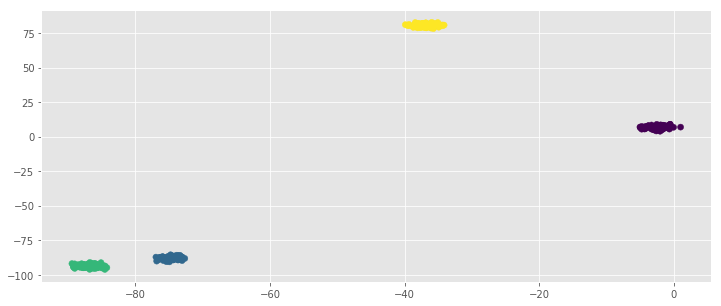

In [240]:
ar = (1,1,1,1,1,0,0,0,0,0)
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

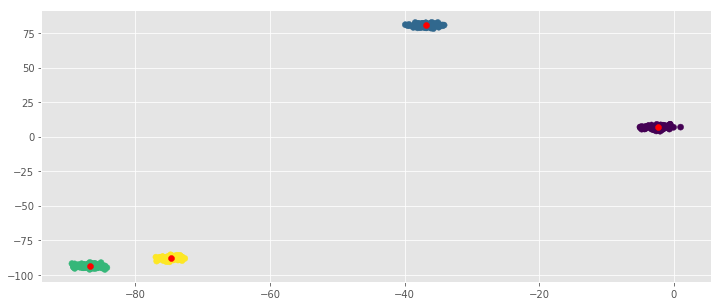

In [242]:
## Работоспособность KMeans
def test_func():    
    
    model = Kmeans(k = 4, random_state=2412, max_iter=4000)
    model.fit(X)
    colors = model.predict(X)
    centroids = model.get_centroids()
    
    plt.scatter(X[:,0], X[:, 1], c=colors)
    plt.scatter(centroids[:,0], centroids[:, 1], c='red')
    
test_func()

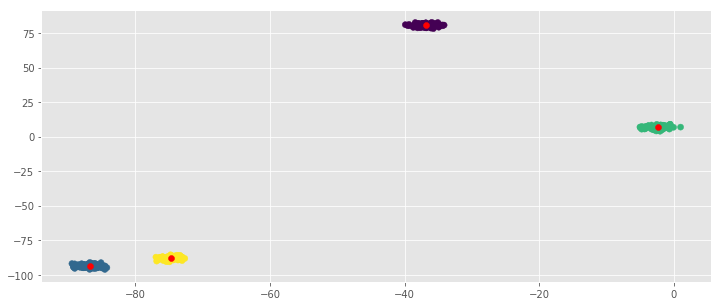

In [243]:
## Работоспособность KMeans++
def test_func():

    model = KmeansPP(k = 4, random_state=2412, max_iter=4000)
    model.fit(X)
    colors = model.predict(X)
    centroids = model.get_centroids()
    
    plt.scatter(X[:,0], X[:, 1], c=colors)
    plt.scatter(centroids[:,0], centroids[:, 1], c='red')

test_func()

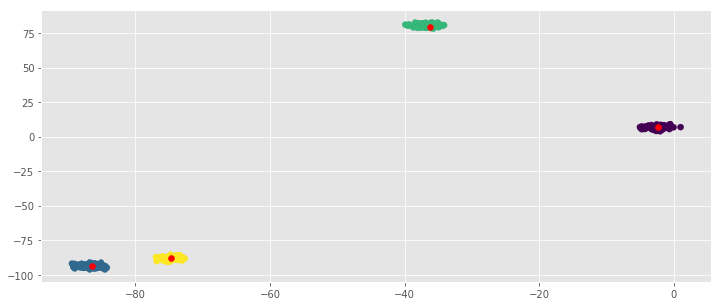

In [245]:
## Работоспособность KMeans с MiniBatchKMeans
def test_func():

    model = MiniBatchKMeans(k = 4, random_state=2412, max_iter=50, batch_size=100)
    model.fit(X)
    colors = model.predict(X)
    centroids = model.get_centroids()
    
    plt.scatter(X[:,0], X[:, 1], c=colors)
    plt.scatter(centroids[:,0], centroids[:, 1], c='red')

test_func()

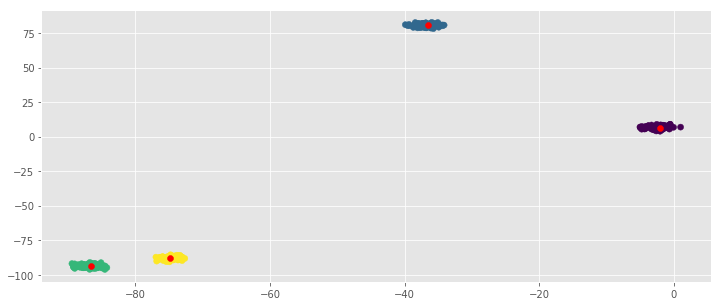

In [252]:
## Работоспособность KMeans++ с MiniBatchKMeans
def test_func():

    model = KmeansPPWitiMiniButch(k = 4, random_state=2412, max_iter=10, batch_size=10)
    model.fit(X)
    colors = model.predict(X)
    centroids = model.get_centroids()
    
    plt.scatter(X[:,0], X[:, 1], c=colors)
    plt.scatter(centroids[:,0], centroids[:, 1], c='red')

test_func()

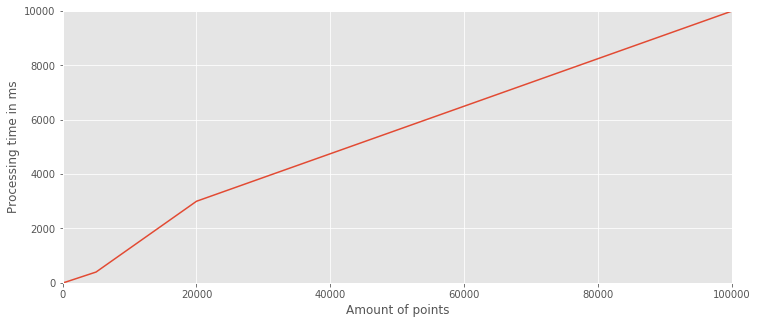

In [266]:
"""
Так как этот алгоритм самый медленный, то для наглядности везде оси сделал такими же как здесь
"""
import matplotlib.pyplot as plt
plt.ylabel('Processing time in ms')
plt.xlabel('Amount of points')
plt.axis([0, 100000, 0, 10000])
plt.plot([100, 500, 5000, 20000, 100000], [3.59, 30, 396, 3000, 10000])
plt.show()


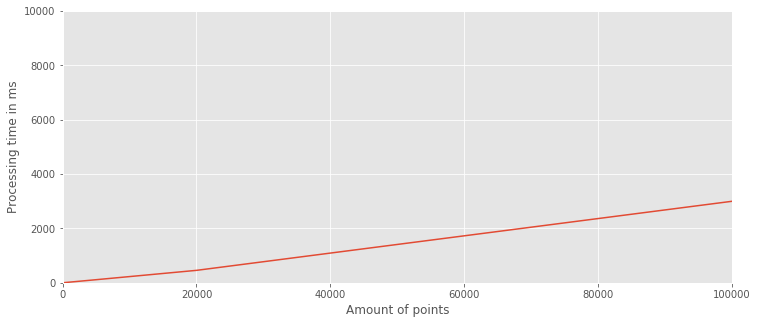

In [251]:
## Время выполнения алгоритма KMeans++
import matplotlib.pyplot as plt
plt.ylabel('Processing time in ms')
plt.xlabel('Amount of points')
plt.axis([0, 100000, 0, 10000])
plt.plot([100, 500, 5000, 20000, 100000], [4, 12, 114, 458, 3000])
plt.show()

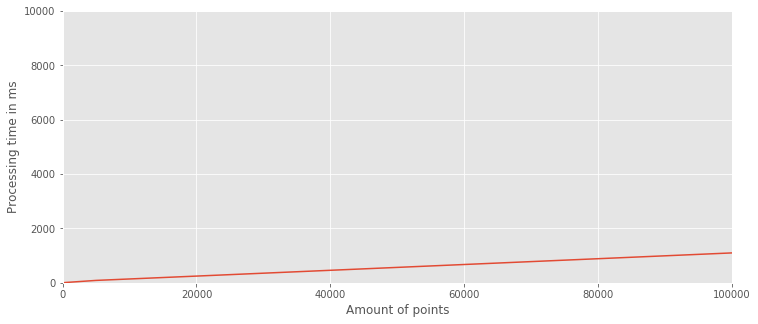

In [250]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
import matplotlib.pyplot as plt
plt.ylabel('Processing time in ms')
plt.xlabel('Amount of points')
plt.axis([0, 100000, 0, 10000])
plt.plot([100, 500, 5000, 20000, 100000], [2.77, 12, 88, 247, 1100])
plt.show()

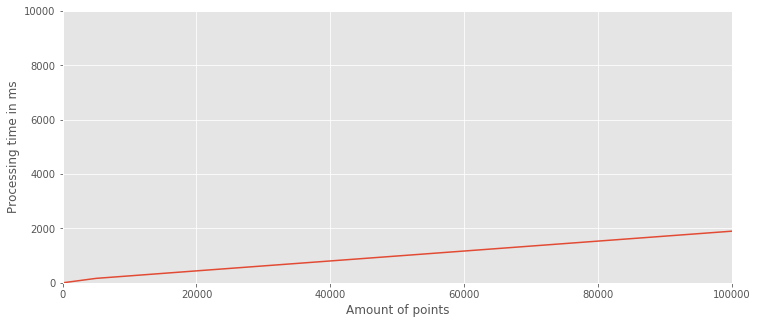

In [249]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
import matplotlib.pyplot as plt
plt.ylabel('Processing time in ms')
plt.xlabel('Amount of points')
plt.axis([0, 100000, 0, 10000])
plt.plot([100, 500, 5000, 20000, 100000], [3, 15, 163, 439, 1900])
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [457]:
df_sns = pd.read_csv('/Users/m.gorbushin/snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,2,1,0,0,0,6,4,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,1,1,0,3,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,1,1


In [458]:
dropped = df_sns.drop(df_sns.columns[[0, 1, 2, 3]], axis=1)
for column in dropped.columns:
    mean = dropped[column].mean()
    std = dropped[column].std()
    dropped[column] -= mean
    dropped[column] /= std

X = dropped.values

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [439]:
## KMeans
model = MiniBatchKMeans(k = 9, random_state=2412, max_iter=100)
model.fit(X)
colors = model.predict(X)
centroids = model.get_centroids()

In [443]:
## KMeans++
model = KmeansPP(k = 9, random_state=2412, max_iter=100)
model.fit(X)
colors = model.predict(X)
centroids = model.get_centroids()

In [448]:
## KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k = 9, random_state=2412, max_iter=200, batch_size=100)
model.fit(X)
colors = model.predict(X)
centroids = model.get_centroids()

In [461]:
## KMeans++ с MiniBatchKMeans
model = KmeansPPWitiMiniButch(k = 9, random_state=2412, max_iter=400, batch_size=200)
model.fit(X)
colors = model.predict(X)
centroids = model.get_centroids()

In [462]:
## Вывод
#пытаемся анализировать, выведем по каждому кластеру среднее арифмитическое его полей
all_clusters = []
for cluster in range(9):
    array = []
    for i in range(0, colors.shape[0]):
        if (colors[i] == cluster):
            array.append(X[i])

    df = pd.DataFrame(array, columns=dropped.columns)
    mean_values = []
    for column in df.columns:
        mean = df[column].mean()
        mean_values.append(mean)
    all_clusters.append(mean_values)

df_mean = pd.DataFrame(all_clusters, columns=df.columns)
df_mean
# 1) сразу выделяется класс - спортсмены, значение basketball, football, soccer итд у них больше 0, а среднее в 
# некоторых столбцах больше 4
# 2) второй класс, который выделяется сразу - cheerleading, среднее значение этого поля больше 7
# 3) аналогично можно заметить класс - sexy, среднее значение больше 7
# давайте у каждого кластера после усреднения колонок выведем поле с минимальным и максимальным значением

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.239954,0.190248,0.185219,0.361914,0.321407,0.543994,0.422490,-0.009456,0.075841,0.050977,0.770901,-0.051394,0.290769,0.635387,-0.065369,0.433300,0.034458,0.000551,0.194011,0.030965,0.100105,0.548567,0.024066,-0.008136,0.214912,-0.015965,0.017751,0.660711,1.019108,0.526101,-0.021756,-0.060966,-0.004516,-0.051031,-0.069595,-0.082318
1,-0.106071,-0.098916,-0.055905,-0.087642,-0.082993,-0.129704,-0.111984,-0.074251,-0.032704,-0.086393,-0.208022,-0.101341,-0.098456,-0.153527,-0.141474,-0.148525,-0.058550,-0.020606,-0.133948,-0.116590,-0.115483,-0.148580,-0.079569,-0.063335,-0.207687,-0.158778,-0.029029,-0.195364,-0.252412,-0.198569,-0.157698,-0.149461,-0.109540,-0.134413,-0.139030,-0.118589
2,-0.007366,-0.008068,-0.056009,-0.034561,-0.075302,-0.009536,-0.068276,-0.075867,0.002797,-0.024900,0.047874,0.047386,-0.022207,-0.084081,-0.028313,0.088233,0.175265,0.077625,0.300902,0.197966,2.018294,0.710732,1.973677,1.588860,0.085686,-0.005471,-0.003958,-0.017234,-0.077080,0.084961,-0.105469,-0.085992,1.225501,3.004610,-0.016500,0.046352
3,-0.332212,-0.357691,-0.242870,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,-0.402356,-0.186381,-0.267318,-0.264221,-0.202616,-0.365711,-0.267790,-0.141419,-0.589151,-0.337787,38.366366,0.901448,51.379503,53.647346,-0.384866,-0.246902,-0.050936,-0.369909,-0.487306,1.801583,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
4,0.791111,0.726449,0.275869,0.182709,0.197537,0.193716,0.198034,1.271732,0.145059,1.043252,0.339053,1.265041,0.443156,0.180229,2.035555,0.352903,0.647999,0.359148,1.056579,1.492774,0.201281,0.117590,0.000633,0.052210,1.767645,0.145747,0.223548,0.425252,0.080095,0.857912,-0.027550,0.064679,0.774692,0.268633,0.598594,1.824943
5,-0.049349,0.106422,0.010870,0.013729,-0.031833,0.051694,0.016441,-0.058967,-0.015571,0.115494,0.193652,0.482881,0.342763,0.120096,0.369814,0.197463,0.043106,-0.061242,0.080680,0.095349,0.144835,0.042829,-0.047563,0.020729,0.523587,0.100222,0.022802,0.192506,0.074062,0.145759,-0.024470,-0.045799,0.258070,0.271301,6.219525,0.454264
6,0.157596,0.199449,0.100142,0.076171,0.202176,0.233217,0.390737,0.023050,0.136493,0.110058,0.380344,0.035356,0.113534,0.407053,0.105088,0.212759,-0.080662,-0.092531,0.132757,0.055121,-0.003336,-0.022693,-0.021749,-0.035663,0.454545,0.047164,0.060464,0.613495,0.783373,0.564287,4.132475,3.975621,0.047933,0.099958,0.002311,0.051890
7,1.213570,1.717025,0.342139,1.100990,0.424258,1.108178,0.835941,1.061100,0.774665,4.103767,2.637150,11.254310,1.856747,0.652045,7.985920,1.354609,1.410859,0.028494,5.389775,3.352705,1.287812,0.901448,0.352421,0.849220,7.834386,2.520792,4.771059,1.417930,1.768585,3.917358,2.963539,3.045093,4.626096,3.423850,3.323942,4.836961
8,0.120052,0.160641,0.008305,0.075474,0.110254,0.011284,0.110770,-0.053934,0.086183,-0.041960,0.444393,0.003818,0.048740,0.101623,0.131708,0.902271,0.182853,0.003958,0.108026,0.028374,0.060012,0.242899,-0.003237,-0.022668,0.417960,5.250615,0.004933,0.407520,0.618914,0.289810,-0.004093,-0.027762,0.058073,0.009839,-0.074002,0.028026


In [ ]:
"""
 По следующей таблице уже становится понятно, кто есть кто
 любители выпить, спортсмены, верующий, sexy, военные (любят маршировать), (те кого считают милыми) итд
 
 Kmeans: 
     Четко выделяются кластеры: 
         1) любители одежды, не любят спорт, возможно модные парни и девушки
         2) любители спорта и не любители одежды, не sexy. Возможно спортсмены, которые не так следят за собой
         3) верующие, при чем они не интересуются модным брендами и спортом
         4) музыканты, судя по средним значениям, они увлекаются всем понемногу, но особый интерес к музыке
         5) еще определился класс "блондинка", он не имеет ни одного положительного поля (блондинка - самое положительное 
            из всех отрицательных), видимо это люди, которые не интересуются совсем ни чем
            
 KmeansPP:
     Мы нашли еще один очень интересный класс:
         6)   Блондинки, среднее значение 168! Значение die - 9.3, death - 13.4, drunk - 14.8
              Похоже на депрессивного эмо подростка
         6.1) Есть другой класс - у которого самое большое значение по наркотикам - 2.7, die, death, drunk на 
              втором месте после эмо подростка, при чем они интересуются одеждой, тц и прической, возможно, что это
              кто-то вроде тех эмо или кто-то вроде "золотой молодежи" в плохом смысле этого слова
              
 KMeans с MiniBatchKMeans:
     Тут мы тоже нашли подобие эмо подростков, в другом свете, но снова выделяются два кластера похожие на 6 и 6.1
         7) Нашли любителей танцев, у них средние значения в спорте близки к нулю, что говорит о том, что они в целом
            заинтересовано, но не до фанатизма
            
 KMeans++ с MiniBatchKMeans:
     Тут очень четко выделился кластер с верующими, они много интересуются богом, церковью, и... смертью
         8) Можно выделить это в отдельный кластер - милые люди, если посмотреть на данные, то становится понятно, что
            люди которые занимаются спортом, танцами считают милыми, горячими и сексуальными чаще других
         9) в качестве притянутого за уши, но все выявившего класса можно выделить класс видимо военных, к сожалению, они как
            класс 5 показывают не за
"""

In [463]:
df_mean.insert(loc = 0, column='min', value=df_mean[dropped.columns].idxmin(axis=1))
df_mean.insert(loc = 1, column='max', value=df_mean[dropped.columns].idxmax(axis=1))
df_mean

,min,max,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,drugs,shopping,0.239954,0.190248,0.185219,0.361914,0.321407,0.543994,0.422490,-0.009456,0.075841,0.050977,0.770901,-0.051394,0.290769,0.635387,-0.065369,0.433300,0.034458,0.000551,0.194011,0.030965,0.100105,0.548567,0.024066,-0.008136,0.214912,-0.015965,0.017751,0.660711,1.019108,0.526101,-0.021756,-0.060966,-0.004516,-0.051031,-0.069595,-0.082318
1,shopping,marching,-0.106071,-0.098916,-0.055905,-0.087642,-0.082993,-0.129704,-0.111984,-0.074251,-0.032704,-0.086393,-0.208022,-0.101341,-0.098456,-0.153527,-0.141474,-0.148525,-0.058550,-0.020606,-0.133948,-0.116590,-0.115483,-0.148580,-0.079569,-0.063335,-0.207687,-0.158778,-0.029029,-0.195364,-0.252412,-0.198569,-0.157698,-0.149461,-0.109540,-0.134413,-0.139030,-0.118589
2,hollister,death,-0.007366,-0.008068,-0.056009,-0.034561,-0.075302,-0.009536,-0.068276,-0.075867,0.002797,-0.024900,0.047874,0.047386,-0.022207,-0.084081,-0.028313,0.088233,0.175265,0.077625,0.300902,0.197966,2.018294,0.710732,1.973677,1.588860,0.085686,-0.005471,-0.003958,-0.017234,-0.077080,0.084961,-0.105469,-0.085992,1.225501,3.004610,-0.016500,0.046352
3,music,bible,-0.332212,-0.357691,-0.242870,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,-0.402356,-0.186381,-0.267318,-0.264221,-0.202616,-0.365711,-0.267790,-0.141419,-0.589151,-0.337787,38.366366,0.901448,51.379503,53.647346,-0.384866,-0.246902,-0.050936,-0.369909,-0.487306,1.801583,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
4,hollister,kissed,0.791111,0.726449,0.275869,0.182709,0.197537,0.193716,0.198034,1.271732,0.145059,1.043252,0.339053,1.265041,0.443156,0.180229,2.035555,0.352903,0.647999,0.359148,1.056579,1.492774,0.201281,0.117590,0.000633,0.052210,1.767645,0.145747,0.223548,0.425252,0.080095,0.857912,-0.027550,0.064679,0.774692,0.268633,0.598594,1.824943
5,marching,drunk,-0.049349,0.106422,0.010870,0.013729,-0.031833,0.051694,0.016441,-0.058967,-0.015571,0.115494,0.193652,0.482881,0.342763,0.120096,0.369814,0.197463,0.043106,-0.061242,0.080680,0.095349,0.144835,0.042829,-0.047563,0.020729,0.523587,0.100222,0.022802,0.192506,0.074062,0.145759,-0.024470,-0.045799,0.258070,0.271301,6.219525,0.454264
6,marching,hollister,0.157596,0.199449,0.100142,0.076171,0.202176,0.233217,0.390737,0.023050,0.136493,0.110058,0.380344,0.035356,0.113534,0.407053,0.105088,0.212759,-0.080662,-0.092531,0.132757,0.055121,-0.003336,-0.022693,-0.021749,-0.035663,0.454545,0.047164,0.060464,0.613495,0.783373,0.564287,4.132475,3.975621,0.047933,0.099958,0.002311,0.051890
7,marching,sex,1.213570,1.717025,0.342139,1.100990,0.424258,1.108178,0.835941,1.061100,0.774665,4.103767,2.637150,11.254310,1.856747,0.652045,7.985920,1.354609,1.410859,0.028494,5.389775,3.352705,1.287812,0.901448,0.352421,0.849220,7.834386,2.520792,4.771059,1.417930,1.768585,3.917358,2.963539,3.045093,4.626096,3.423850,3.323942,4.836961
8,drunk,dress,0.120052,0.160641,0.008305,0.075474,0.110254,0.011284,0.110770,-0.053934,0.086183,-0.041960,0.444393,0.003818,0.048740,0.101623,0.131708,0.902271,0.182853,0.003958,0.108026,0.028374,0.060012,0.242899,-0.003237,-0.022668,0.417960,5.250615,0.004933,0.407520,0.618914,0.289810,-0.004093,-0.027762,0.058073,0.009839,-0.074002,0.028026
